In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.utils import shuffle
import time
import scipy.io
%matplotlib inline

## Model

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

def tanh_prime(x):
    return 1 - np.tanh(x)**2

def relu_prime(x):
    return np.where(x > 0, 1, 0)

In [3]:
class QuadraticCost(object):
    @staticmethod
    def fn(a, y):
        return 0.5 * np.linalg.norm(a-y)**2

    @staticmethod
    def delta(z, a, y):
        return (a-y) * tanh_prime(z)
    
class CrossEntropyCost(object):
    @staticmethod
    def fn(a, y):
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))
    
    @staticmethod
    def delta(z, a, y):
        return (a-y)
    
class Sigmoid(object):
    @staticmethod
    def activate(z):
        return 1.0/(1.0+np.exp(-z))
    
    @staticmethod
    def delta(z):
        return sigmoid(z)*(1-sigmoid(z))
    
class Tanh(object):
    @staticmethod
    def activate(z):
        return np.tanh(z)
    
    @staticmethod
    def delta(z):
        return 1.0 - np.tanh(z)**2
    
class ReLU(object):
    @staticmethod
    def activate(z):
        return np.maximum(0, z)
    
    @staticmethod
    def delta(z):
        return np.where(z > 0, 1, 0)
    
class Network(object):
    def __init__(self, sizes, cost=CrossEntropyCost, func=Sigmoid):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.weight_initializer()
        self.cost=cost
        self.func=func

    def weight_initializer(self):
        self.weights = [np.random.randn(y, x) for x, y in zip(self.sizes[:-1], self.sizes[1:])]
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]

    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = (self.func).activate(np.dot(w, a)+b)
        return a
    
    def train(self, training_data, epochs, learning_rate, save=False):
        n = len(training_data)
        log_file = open("log.txt", "w")  # records loss for each epoch
        log_file.write("Number of epochs: %d, Learning rate: %f\n" % (epochs, learning_rate))
    
        # perform gradient check using numerical approximation
        # self.gradient_check(training_data)

        # Initialize a list to store loss for each epoch
        losses = []
    
        for j in range(epochs):
            error_b = [np.zeros(b.shape) for b in self.biases]
            error_w = [np.zeros(w.shape) for w in self.weights]
            for (x, y) in training_data:
                delta_error_b, delta_error_w = self.backprop(x, y)
                error_b = [(eb+deb/n) for eb, deb in zip(error_b, delta_error_b)]
                error_w = [(ew+dew/n) for ew, dew in zip(error_w, delta_error_w)]
    
            loss = self.loss(training_data)
            log_file.write("Epoch %d: %f\n" % (j, loss))
            log_file.flush()  # Flush the file to disk after writing each line
            losses.append(loss)
    
            self.weights = [w-learning_rate*ew for w, ew in zip(self.weights, error_w)]
            self.biases = [b-learning_rate*eb for b, eb in zip(self.biases, error_b)]                
    
        log_file.close()

        if save:
            self.save("model.txt")

    def backprop(self, x, y):
        error_b = [np.zeros(b.shape) for b in self.biases]
        error_w = [np.zeros(w.shape) for w in self.weights]
        activation = x
        activations = [x]
        zs = []
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = (self.func).activate(z)
            activations.append(activation)
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        error_w[-1] = np.dot(delta, activations[-2].transpose())
        error_b[-1] = delta
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = (self.func).delta(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            error_w[-l] = np.dot(delta, activations[-l-1].transpose())
            error_b[-l] = delta
        return (error_b, error_w)
    
    def loss(self, data):
        loss = 0
        for x, y in data:
            a = self.feedforward(x)
            # if convert: y = vectorized_result(y)
            loss += self.cost.fn(a, y)/len(data)
        return loss
    
    def save(self, filename):
        # save with the following format: sizes, weights, biases, cost, func line by line
        with open(filename, "w") as f:
            f.write("%s\n" % self.sizes)
            for w in self.weights:
                for row in w:
                    f.write("%s\n" % row)
            for b in self.biases:
                for row in b:
                    f.write("%s\n" % row)
            f.write("%s\n" % self.cost)
            f.write("%s\n" % self.func)
        f.close()

    def test(self, test_data, error=False):
        # use softmax to convert the output to probabilities
        test_results = [(1 if self.feedforward(x) > 0.5 else 0, y) for (x, y) in test_data]
        accuracy = np.mean([int(x == y) for (x, y) in test_results])
        # print("Accuracy: ", accuracy)
        # print(test_results)
        if error:
            return 1 - accuracy
        return accuracy

    
    def gradient_check(self, training_data):
        epsilon = 1e-7
        tolerance = 1e-3
        
        for x, y in training_data:
            backprop_b, backprop_w = self.backprop(x, y)

            for i in range(len(self.biases)):
                for j in range(len(self.biases[i])):
                    original_bias = self.biases[i][j]
                    self.biases[i][j] += epsilon
                    loss_plus = self.loss([(x, y)])
                    self.biases[i][j] -= 2*epsilon
                    loss_minus = self.loss([(x, y)])
                    self.biases[i][j] = original_bias
                    numerical_gradient = (loss_plus - loss_minus) / (2*epsilon)

                    if abs(numerical_gradient - backprop_b[i][j]) > tolerance:
                        print("Gradient check failed for bias[%d][%d]: %f vs %f" % (i, j, numerical_gradient, backprop_b[i][j]))

            for i in range(len(self.weights)):
                for j in range(len(self.weights[i])):
                    for k in range(len(self.weights[i][j])):
                        original_weight = self.weights[i][j][k]
                        self.weights[i][j][k] += epsilon
                        loss_plus = self.loss([(x, y)])
                        self.weights[i][j][k] -= 2*epsilon
                        loss_minus = self.loss([(x, y)])
                        self.weights[i][j][k] = original_weight
                        numerical_gradient = (loss_plus - loss_minus) / (2*epsilon)

                        if abs(numerical_gradient - backprop_w[i][j][k]) > tolerance:
                            print("Gradient check failed for weight[%d][%d][%d]: %f vs %f" % (i, j, k, numerical_gradient, backprop_w[i][j][k]))

def vectorized_result(j):
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [4]:
def load_network():
    file = open("network.txt", "r")
    # format: sizes, cost function, activation function each on a separate line 
    sizes = list(map(int, file.readline().split()))

    # Read the cost function and activation function names
    cost_fn_name = file.readline().strip()
    activation_fn_name = file.readline().strip()

    # Mapping of cost function names to classes
    cost_fn_mapping = {
        "QuadraticCost": QuadraticCost,
        "CrossEntropyCost": CrossEntropyCost
    }

    # Mapping of activation function names to classes
    activation_fn_mapping = {
        "Sigmoid": Sigmoid,
        "Tanh": Tanh,
        "ReLU": ReLU
    }

    # Get the actual classes based on the names read from the file
    cost_fn = cost_fn_mapping.get(cost_fn_name, CrossEntropyCost)  # Default to CrossEntropyCost if not found
    activation_fn = activation_fn_mapping.get(activation_fn_name, Sigmoid)  # Default to Sigmoid if not found

    # Initialize the network with the correct classes
    net = Network(sizes, cost=cost_fn, func=activation_fn)
    print(sizes, cost_fn_name, activation_fn_name)
    return net

## GloVe

In order to download the GloVe file go to https://nlp.stanford.edu/projects/glove/ and download the file Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors, 822 MB download). Then place the downloaded file in the current directory and the proceed with the execution of the following cells.

In [5]:
import gensim
import nltk
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors
from nltk.tokenize import word_tokenize, sent_tokenize

In [7]:
glove_input_file = './glove.6B.50d.txt'  # Adjust the path and filename as necessary
word2vec_output_file = 'glove.6B.50d.word2vec.txt'
glove2word2vec(glove_input_file, word2vec_output_file)

# Load the converted vectors
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

C:\Users\K S Ananth\AppData\Local\Temp\ipykernel_16072\3724047408.py:3: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


In [8]:
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Ensure you have downloaded the necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

def get_vector_of_sentence(sentence, model):
    # Initialize a lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Convert sentence to lowercase and split into words
    words = sentence.lower().split()
    
    # Filter out stopwords
    filtered_words = [word for word in words if word not in stopwords.words('english')]
    
    vector = np.zeros(model.vector_size)
    total_words = 0
    
    for word in filtered_words:
        # Lemmatize the word
        lemmatized_word = lemmatizer.lemmatize(word)
        total_words += 1

        if lemmatized_word in model.key_to_index:  # Check if the lemmatized word is in the model
            vector += model.get_vector(lemmatized_word)
    
    if total_words > 0:
        vector /= total_words
    
    return vector

[nltk_data] Downloading package stopwords to C:\Users\K S
[nltk_data]     Ananth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\K S
[nltk_data]     Ananth\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load SST2 or MR Dataset and make the required adjustments

In [9]:
# from datasets import load_dataset
# ds = load_dataset("stanfordnlp/sst2")

from datasets import load_dataset
ds = load_dataset("cornell-movie-review-data/rotten_tomatoes")

In [10]:
from datasets import concatenate_datasets
combined_dataset = concatenate_datasets([ds['train'], ds['validation'], ds['test']])

In [11]:
# Vectorize all sentences
# sentence_vectors = [get_vector_of_sentence(item['sentence'], model) for item in combined_dataset]
sentence_vectors = [get_vector_of_sentence(item['text'], model) for item in combined_dataset]

# Extract labels
labels = [item['label'] for item in combined_dataset]

# Split into training and test sets
X_train_sentence, X_test_sentence, y_train, temp_y_test = train_test_split(sentence_vectors, labels, test_size=0.2, random_state=42)

# Convert lists to NumPy arrays for compatibility with many ML libraries
X_train = np.array(X_train_sentence)
y_train = np.array(y_train)
X_test = np.array(X_test_sentence)
y_test = np.array(temp_y_test)

test_inputs = [np.reshape(x, (len(x), 1)) for x in X_test_sentence]
test_results = [np.reshape(y, (1, 1)) for y in temp_y_test]
test_data = list(zip(test_inputs, test_results))

training_data = list(zip(X_train, y_train))

In [12]:
len(X_train)

8529

## Sentiment Analysis

In [13]:
len(training_data)

8529

In [18]:
net = load_network()

[50, 32, 16, 10, 1] QuadraticCost Tanh


0.5457102672292545
Number of iterations:  200
Average iteration time:  0.18804962311557788
Total time:  37.421875
0.536333802156587


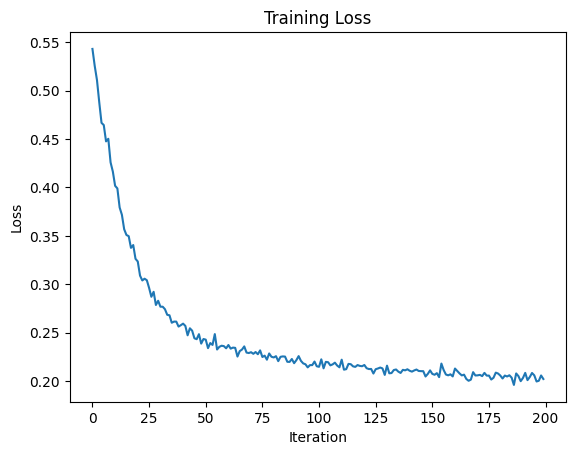

In [19]:
n = len(training_data)
k = n//2

initial_eta = 0.01
decay_rate = 0.96
decay_step = 100
decay = 0.001

iterations = 1
losses = []
previous_loss = 0
iteration_time = []
# np.random.seed(42)
print(net.test(test_data))
while True:
    time1 = time.process_time()
    random_seed = random.randint(0, n)
    np.random.seed(random_seed)
    indices = np.random.choice(n, k, replace=False)
    temp_X_train = X_train[indices]
    temp_y_train = y_train[indices]
    training_inputs = [np.reshape(x, (len(x), 1)) for x in temp_X_train]
    training_results = [np.reshape(y, (1, 1)) for y in temp_y_train]
    temp_training_data = list(zip(training_inputs, training_results))

    eta = initial_eta / (1 + decay * iterations)
    # eta = initial_eta * decay_rate ** (iterations / decay_step)
    net.train(temp_training_data, 1, eta)
    temp = Network.loss(net, temp_training_data)
    losses.append(temp)
    # if abs(temp - previous_loss) < 1e-7 or iterations == 8000:
    #     break
    if(iterations == 200):
       break
    previous_loss = temp
    iterations += 1
    time2 = time.process_time()
    iteration_time.append(time2 - time1)

print("Number of iterations: ", iterations)
print("Average iteration time: ", np.mean(iteration_time))
print("Total time: ", np.sum(iteration_time))
print(net.test(test_data))
plt.figure()
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [24]:
temp = get_vector_of_sentence("The movie was bad", model)
temp = np.reshape(temp, (len(temp), 1))
prediction = net.feedforward(temp)
print(prediction)
if prediction >= 0:
    print("Positive")
else:
    print("Negative")

[[0.85104672]]
Positive


In [25]:
net.test(test_data)

0.536333802156587